# 使用 NeuralOP 库的 FNO 求解 Navier-Stokes 方程

本笔记本演示如何使用 `neuralop` 库中预构建的 FNO 模型来求解 2D Navier-Stokes 方程，而不需要手动构建 FNO 网络结构。

## 项目概述
- **目标**: 使用时间递归结构预测 Navier-Stokes 方程的时间演化
- **输入**: 前 10 个时间步的解 + 空间坐标 (u(t-10), ..., u(t-1), x, y)
- **输出**: 下一个时间步的解 u(t)
- **优势**: 相比手动实现，使用 neuralop 库可以大大简化代码并提供更稳定的实现

## 1. 导入必要的库

In [4]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from timeit import default_timer
import scipy.io

# NeuralOP 库导入
from neuralop.models import FNO

# 工具函数导入（假设您有 utilities3.py 文件）
try:
    from utilities3 import *
except ImportError:
    print("Warning: utilities3.py not found. Defining necessary functions.")
    
    class MatReader(object):
        def __init__(self, file_path):
            self.data = scipy.io.loadmat(file_path)
        
        def read_field(self, field):
            return torch.tensor(self.data[field], dtype=torch.float32)
    
    class LpLoss(object):
        def __init__(self, d=2, p=2, size_average=True, reduction=True):
            super(LpLoss, self).__init__()
            self.d = d
            self.p = p
            self.reduction = reduction
            self.size_average = size_average

        def __call__(self, x, y):
            num_examples = x.size()[0]
            diff_norms = torch.norm(x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1)
            y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
            
            if self.reduction:
                if self.size_average:
                    return torch.mean(diff_norms / y_norms)
                else:
                    return torch.sum(diff_norms / y_norms)
            
            return diff_norms / y_norms

# 设置随机种子
torch.manual_seed(0)
np.random.seed(0)

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. 配置参数

设置与原始 `fourier_2d_time.py` 相同的参数配置。

In [5]:
################################################################
# 配置参数
################################################################
TRAIN_PATH = '/home/yc/FNO/data/NavierStokes_V1e-5_N1200_T20.mat'
TEST_PATH = '/home/yc/FNO/data/NavierStokes_V1e-5_N1200_T20.mat'

ntrain = 1000
ntest = 200

# FNO 模型参数
modes = 12  # Fourier 模式数
width = 20  # 通道宽度

# 训练参数
batch_size = 20
epochs = 500
learning_rate = 0.0025
scheduler_step = 100
scheduler_gamma = 0.5

# 数据参数
sub = 1
S = 64        # 空间分辨率
T_in = 10     # 输入时间步数
T = 10        # 预测时间步数
step = 1      # 时间步长

# 输出配置
path = f'ns_neuralop_fno_V10000_T20_N{ntrain}_ep{epochs}_m{modes}_w{width}'
path_model = f'model/{path}'
path_train_err = f'results/{path}train.txt'
path_test_err = f'results/{path}test.txt'

print(f"Training epochs: {epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Scheduler step: {scheduler_step}")
print(f"Scheduler gamma: {scheduler_gamma}")
print(f"Spatial resolution: {S}x{S}")
print(f"Input time steps: {T_in}")
print(f"Prediction time steps: {T}")

Training epochs: 500
Learning rate: 0.0025
Scheduler step: 100
Scheduler gamma: 0.5
Spatial resolution: 64x64
Input time steps: 10
Prediction time steps: 10


## 3. 数据加载和预处理

加载 Navier-Stokes 数据并进行预处理，添加空间坐标信息。

In [6]:
################################################################
# 数据加载
################################################################
t1 = default_timer()

# 加载训练数据
reader = MatReader(TRAIN_PATH)
train_a = reader.read_field('u')[:ntrain, ::sub, ::sub, :T_in]
train_u = reader.read_field('u')[:ntrain, ::sub, ::sub, T_in:T+T_in]

# 加载测试数据
reader = MatReader(TEST_PATH)
test_a = reader.read_field('u')[-ntest:, ::sub, ::sub, :T_in]
test_u = reader.read_field('u')[-ntest:, ::sub, ::sub, T_in:T+T_in]

print(f"Training input shape: {train_a.shape}")
print(f"Training output shape: {train_u.shape}")
print(f"Test input shape: {test_a.shape}")
print(f"Test output shape: {test_u.shape}")

# 验证数据维度
assert (S == train_u.shape[-2])
assert (T == train_u.shape[-1])

# 重塑数据
train_a = train_a.reshape(ntrain, S, S, T_in)
test_a = test_a.reshape(ntest, S, S, T_in)

print(f"Reshaped training input: {train_a.shape}")
print(f"Reshaped test input: {test_a.shape}")

Training input shape: torch.Size([1000, 64, 64, 10])
Training output shape: torch.Size([1000, 64, 64, 10])
Test input shape: torch.Size([200, 64, 64, 10])
Test output shape: torch.Size([200, 64, 64, 10])
Reshaped training input: torch.Size([1000, 64, 64, 10])
Reshaped test input: torch.Size([200, 64, 64, 10])


In [7]:
################################################################
# 添加空间坐标 (x, y)
################################################################

# 创建空间网格坐标
gridx = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridx = gridx.reshape(1, S, 1, 1).repeat([1, 1, S, 1])
gridy = torch.tensor(np.linspace(0, 1, S), dtype=torch.float)
gridy = gridy.reshape(1, 1, S, 1).repeat([1, S, 1, 1])

# 将坐标信息添加到输入数据中
# 最终输入: [前10个时间步的解] + [x坐标] + [y坐标] = 12个通道
train_a = torch.cat((train_a, 
                     gridx.repeat([ntrain, 1, 1, 1]), 
                     gridy.repeat([ntrain, 1, 1, 1])), dim=-1)

test_a = torch.cat((test_a, 
                    gridx.repeat([ntest, 1, 1, 1]), 
                    gridy.repeat([ntest, 1, 1, 1])), dim=-1)

print(f"Final training input shape (with coordinates): {train_a.shape}")
print(f"Final test input shape (with coordinates): {test_a.shape}")
print(f"Input channels: {train_a.shape[-1]} (10 time steps + 2 coordinates)")

# 创建数据加载器
train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(train_a, train_u), 
    batch_size=batch_size, 
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(test_a, test_u), 
    batch_size=batch_size, 
    shuffle=False
)

t2 = default_timer()
print(f'数据预处理完成，用时: {t2-t1:.2f} 秒')

Final training input shape (with coordinates): torch.Size([1000, 64, 64, 12])
Final test input shape (with coordinates): torch.Size([200, 64, 64, 12])
Input channels: 12 (10 time steps + 2 coordinates)
数据预处理完成，用时: 0.66 秒


## 4. 使用 NeuralOP 构建 FNO 模型

这里是关键部分：使用 `neuralop.models.FNO` 替代手动构建的 FNO 网络。相比原始实现，代码大大简化。

In [11]:
################################################################
# 使用 NeuralOP 构建 FNO 模型
################################################################

# 检查设备
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print(f'使用设备: {device}')

# 使用 neuralop 库创建 FNO 模型
# 相比手动实现，这里只需要几行代码！
model = FNO(
    n_modes=(modes, modes),   # Fourier 模式数 (高度, 宽度)
    hidden_channels=width,    # 隐藏层通道数
    in_channels=12,           # 输入通道数（10个时间步 + 2个坐标）
    out_channels=1,           # 输出通道数（下一个时间步的解）
    lifting_channels=256,     # 提升层通道数
    projection_channels=256,  # 投影层通道数
    n_layers=4,               # FNO 层数
).to(device)

print(f"FNO 模型创建成功！")
print(f"模型参数数量: {sum(p.numel() for p in model.parameters())}")

# 打印模型架构
print("\n模型架构:")
print(model)

使用设备: cuda:2
FNO 模型创建成功！
模型参数数量: 140181

模型架构:
FNO(
  (positional_embedding): GridEmbeddingND()
  (fno_blocks): FNOBlocks(
    (convs): ModuleList(
      (0-3): 4 x SpectralConv(
        (weight): DenseTensor(shape=torch.Size([20, 20, 12, 7]), rank=None)
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(20, 20, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
    (channel_mlp): ModuleList(
      (0-3): 4 x ChannelMLP(
        (fcs): ModuleList(
          (0): Conv1d(20, 10, kernel_size=(1,), stride=(1,))
          (1): Conv1d(10, 20, kernel_size=(1,), stride=(1,))
        )
      )
    )
    (channel_mlp_skips): ModuleList(
      (0-3): 4 x SoftGating()
    )
  )
  (lifting): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(14, 40, kernel_size=(1,), stride=(1,))
      (1): Conv1d(40, 20, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): ChannelMLP(
    (fcs): ModuleList(
      (0): Conv1d(20, 40, kernel_size=(1,), str

## 5. 训练配置

设置优化器、学习率调度器和损失函数。

In [12]:
################################################################
# 训练配置
################################################################

# 优化器
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=learning_rate, 
    weight_decay=1e-4
)

# 学习率调度器
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=scheduler_step, 
    gamma=scheduler_gamma
)

# 损失函数
myloss = LpLoss(size_average=False)

# 将网格坐标移到设备上
gridx = gridx.to(device)
gridy = gridy.to(device)

print("训练配置完成！")
print(f"优化器: Adam (lr={learning_rate}, weight_decay=1e-4)")
print(f"调度器: StepLR (step_size={scheduler_step}, gamma={scheduler_gamma})")
print(f"损失函数: L2 相对误差")

训练配置完成！
优化器: Adam (lr=0.0025, weight_decay=1e-4)
调度器: StepLR (step_size=100, gamma=0.5)
损失函数: L2 相对误差


## 6. 训练循环

实现与原始代码相同的时间递归训练策略。模型在每个时间步进行预测，然后将预测结果作为下一个时间步的输入。

In [13]:
################################################################
# 训练和评估
################################################################

# 存储训练历史
train_losses = []
test_losses = []
times = []

print("开始训练...")
print("Epoch | Time | Train Loss (Step) | Train Loss (Full) | Test Loss (Step) | Test Loss (Full)")
print("-" * 90)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_l2_step = 0
    train_l2_full = 0
    
    # 训练循环
    for xx, yy in train_loader:
        loss = 0
        xx = xx.to(device)
        yy = yy.to(device)
        
        # 时间递归预测
        for t in range(0, T, step):
            y = yy[..., t:t + step]
            
            # 调整输入维度以适配 FNO 模型 (batch, channels, height, width)
            xx_input = xx.permute(0, 3, 1, 2)  # (batch, 12, 64, 64)
            
            # FNO 前向传播
            im = model(xx_input)  # 输出: (batch, 1, 64, 64)
            
            # 调整输出维度回原格式 (batch, height, width, channels)
            im = im.permute(0, 2, 3, 1)  # (batch, 64, 64, 1)
            
            # 计算损失
            loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))
            
            # 保存预测结果
            if t == 0:
                pred = im
            else:
                pred = torch.cat((pred, im), -1)
            
            # 更新输入：移除最早的时间步，添加新预测的时间步
            xx = torch.cat((
                xx[..., step:-2],  # 移除最早的 step 个时间步和最后2个坐标
                im,                # 添加新预测的时间步
                gridx.repeat([batch_size, 1, 1, 1]),  # 重新添加 x 坐标
                gridy.repeat([batch_size, 1, 1, 1])   # 重新添加 y 坐标
            ), dim=-1)
        
        train_l2_step += loss.item()
        l2_full = myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1))
        train_l2_full += l2_full.item()
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # 评估
    test_l2_step = 0
    test_l2_full = 0
    model.eval()
    with torch.no_grad():
        for xx, yy in test_loader:
            loss = 0
            xx = xx.to(device)
            yy = yy.to(device)
            
            for t in range(0, T, step):
                y = yy[..., t:t + step]
                
                # FNO 前向传播
                xx_input = xx.permute(0, 3, 1, 2)
                im = model(xx_input)
                im = im.permute(0, 2, 3, 1)
                
                loss += myloss(im.reshape(batch_size, -1), y.reshape(batch_size, -1))
                
                if t == 0:
                    pred = im
                else:
                    pred = torch.cat((pred, im), -1)
                
                xx = torch.cat((
                    xx[..., step:-2], im,
                    gridx.repeat([batch_size, 1, 1, 1]), 
                    gridy.repeat([batch_size, 1, 1, 1])
                ), dim=-1)
            
            test_l2_step += loss.item()
            test_l2_full += myloss(pred.reshape(batch_size, -1), yy.reshape(batch_size, -1)).item()
    
    # 更新学习率
    scheduler.step()
    
    # 计算平均损失
    t2 = default_timer()
    train_step_avg = train_l2_step / ntrain / (T / step)
    train_full_avg = train_l2_full / ntrain
    test_step_avg = test_l2_step / ntest / (T / step)
    test_full_avg = test_l2_full / ntest
    
    # 记录历史
    train_losses.append((train_step_avg, train_full_avg))
    test_losses.append((test_step_avg, test_full_avg))
    times.append(t2 - t1)
    
    # 打印进度
    if ep % 10 == 0 or ep < 10:
        print(f"{ep:4d} | {t2-t1:4.1f}s | {train_step_avg:.6f} | {train_full_avg:.6f} | {test_step_avg:.6f} | {test_full_avg:.6f}")

print("\n训练完成！")

开始训练...
Epoch | Time | Train Loss (Step) | Train Loss (Full) | Test Loss (Step) | Test Loss (Full)
------------------------------------------------------------------------------------------
   0 |  5.7s | 0.703513 | 0.735732 | 0.493206 | 0.529861
   0 |  5.7s | 0.703513 | 0.735732 | 0.493206 | 0.529861
   1 |  5.3s | 0.390424 | 0.429452 | 0.326375 | 0.362858
   1 |  5.3s | 0.390424 | 0.429452 | 0.326375 | 0.362858
   2 |  5.3s | 0.293455 | 0.331079 | 0.274012 | 0.307333
   2 |  5.3s | 0.293455 | 0.331079 | 0.274012 | 0.307333
   3 |  5.4s | 0.257184 | 0.292165 | 0.248112 | 0.281965
   3 |  5.4s | 0.257184 | 0.292165 | 0.248112 | 0.281965
   4 |  5.3s | 0.238363 | 0.272538 | 0.233774 | 0.266090
   4 |  5.3s | 0.238363 | 0.272538 | 0.233774 | 0.266090
   5 |  5.2s | 0.227642 | 0.261378 | 0.225264 | 0.256613
   5 |  5.2s | 0.227642 | 0.261378 | 0.225264 | 0.256613
   6 |  5.2s | 0.217274 | 0.250086 | 0.218260 | 0.249561
   6 |  5.2s | 0.217274 | 0.250086 | 0.218260 | 0.249561
   7 |  5.3s

## 7. 结果可视化

绘制训练和测试损失曲线，分析模型性能。

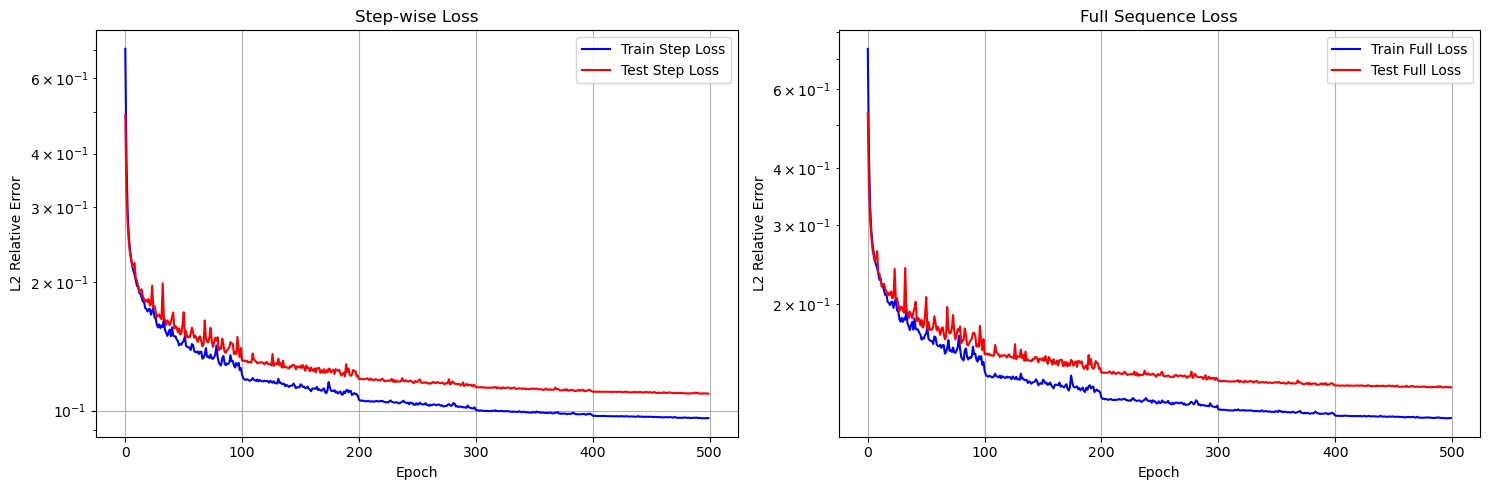


最终结果:
训练步进损失: 0.096063
训练全序列损失: 0.112100
测试步进损失: 0.109558
测试全序列损失: 0.130998
平均训练时间: 5.22 秒/epoch


In [14]:
################################################################
# 结果可视化
################################################################

# 提取损失数据
train_step_losses = [loss[0] for loss in train_losses]
train_full_losses = [loss[1] for loss in train_losses]
test_step_losses = [loss[0] for loss in test_losses]
test_full_losses = [loss[1] for loss in test_losses]

# 绘制损失曲线
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# 步进损失
ax1.plot(train_step_losses, label='Train Step Loss', color='blue')
ax1.plot(test_step_losses, label='Test Step Loss', color='red')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('L2 Relative Error')
ax1.set_title('Step-wise Loss')
ax1.legend()
ax1.grid(True)
ax1.set_yscale('log')

# 全序列损失
ax2.plot(train_full_losses, label='Train Full Loss', color='blue')
ax2.plot(test_full_losses, label='Test Full Loss', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('L2 Relative Error')
ax2.set_title('Full Sequence Loss')
ax2.legend()
ax2.grid(True)
ax2.set_yscale('log')

plt.tight_layout()
plt.show()

# 打印最终结果
print(f"\n最终结果:")
print(f"训练步进损失: {train_step_losses[-1]:.6f}")
print(f"训练全序列损失: {train_full_losses[-1]:.6f}")
print(f"测试步进损失: {test_step_losses[-1]:.6f}")
print(f"测试全序列损失: {test_full_losses[-1]:.6f}")
print(f"平均训练时间: {np.mean(times):.2f} 秒/epoch")

## 8. 模型预测示例

选择一个测试样本，展示模型的预测效果。

In [15]:
################################################################
# 模型预测示例
################################################################

# 选择一个测试样本进行预测
model.eval()
test_sample_idx = 0

with torch.no_grad():
    # 获取测试样本
    x_test = test_a[test_sample_idx:test_sample_idx+1].to(device)  # (1, 64, 64, 12)
    y_test = test_u[test_sample_idx:test_sample_idx+1].to(device)  # (1, 64, 64, 10)
    
    # 预测
    predictions = []
    xx = x_test.clone()
    
    for t in range(0, T, step):
        # FNO 预测
        xx_input = xx.permute(0, 3, 1, 2)  # (1, 12, 64, 64)
        pred = model(xx_input)  # (1, 1, 64, 64)
        pred = pred.permute(0, 2, 3, 1)  # (1, 64, 64, 1)
        
        predictions.append(pred.squeeze().cpu().numpy())  # (64, 64)
        
        # 更新输入
        xx = torch.cat((
            xx[..., step:-2], pred,
            gridx.repeat([1, 1, 1, 1]), 
            gridy.repeat([1, 1, 1, 1])
        ), dim=-1)
    
    # 真实值
    ground_truth = y_test.squeeze().cpu().numpy()  # (64, 64, 10)

print(f"预测形状: {len(predictions)} 个时间步，每个 {predictions[0].shape}")
print(f"真实值形状: {ground_truth.shape}")

预测形状: 10 个时间步，每个 (64, 64)
真实值形状: (64, 64, 10)


时间步 0 相对误差: 0.056309
时间步 2 相对误差: 0.065709
时间步 4 相对误差: 0.082078
时间步 6 相对误差: 0.114248
时间步 8 相对误差: 0.163602
时间步 9 相对误差: 0.203815


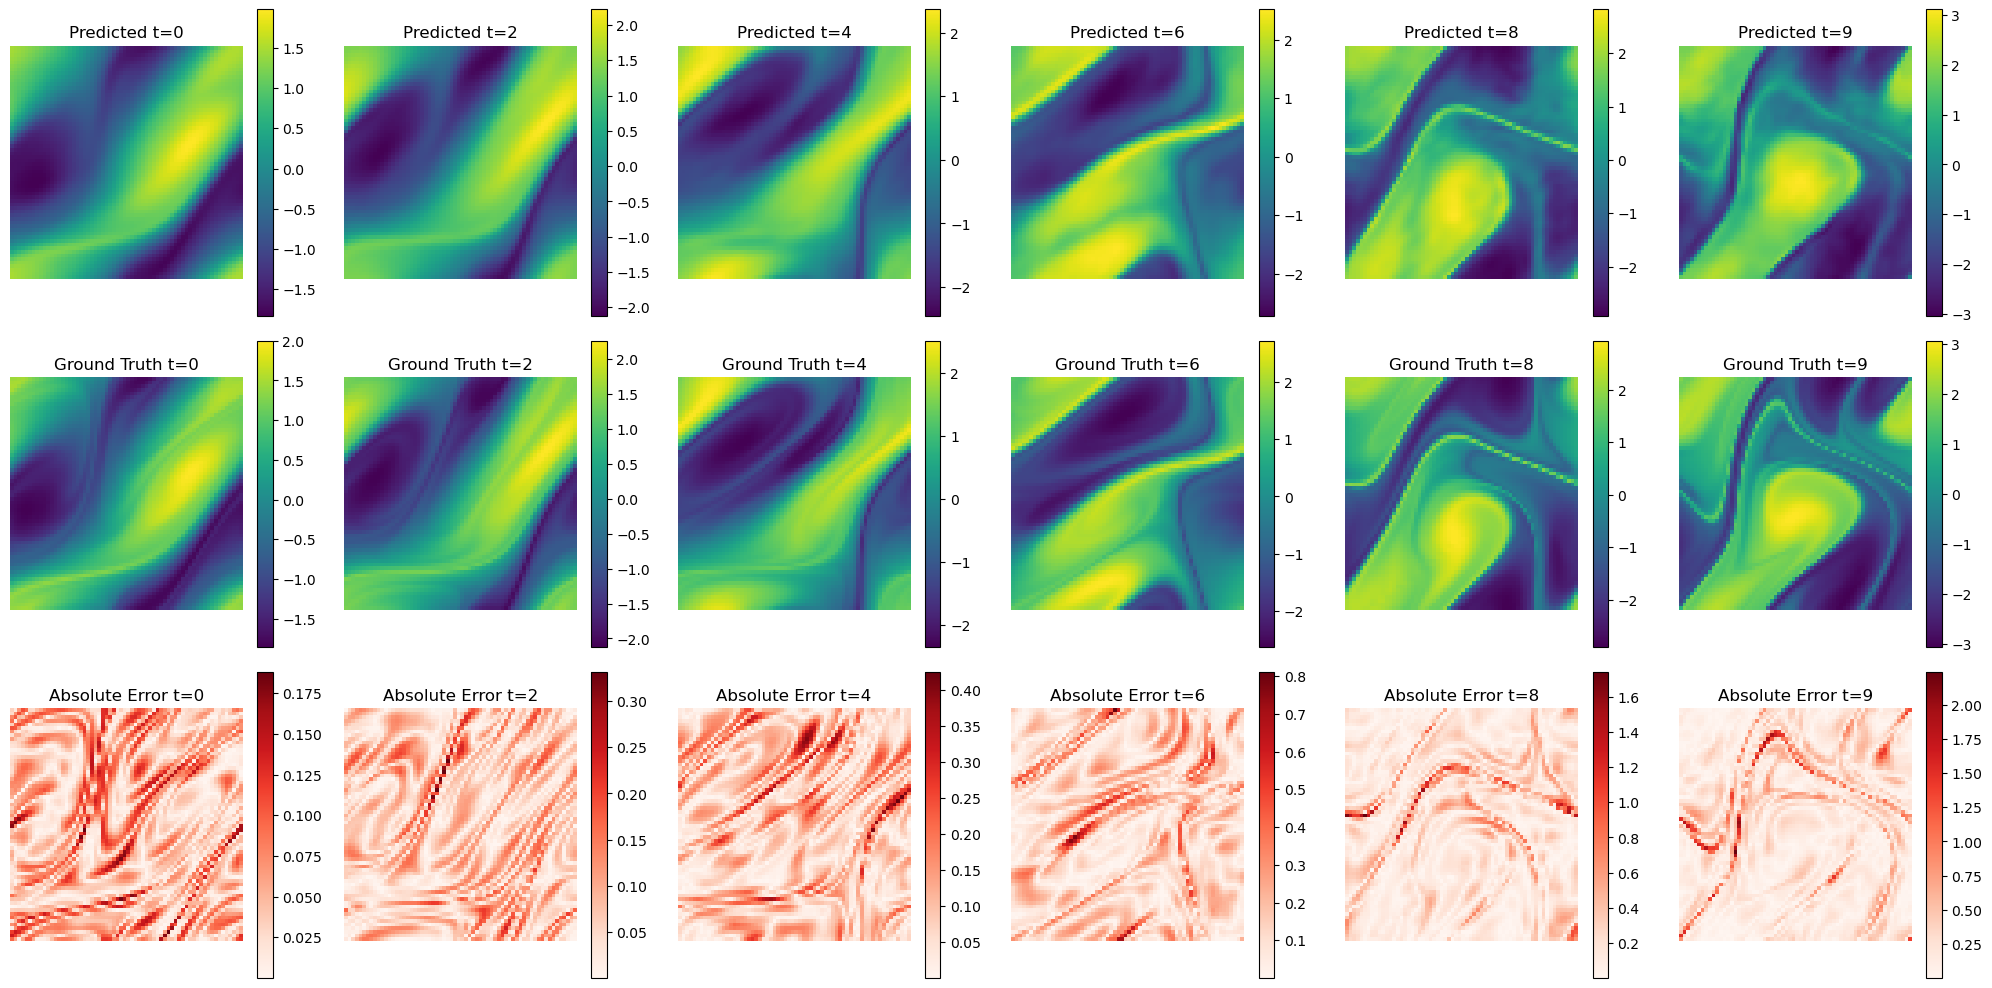

In [16]:
# 可视化预测结果
time_steps_to_show = [0, 2, 4, 6, 8, 9]  # 显示的时间步

fig, axes = plt.subplots(3, len(time_steps_to_show), figsize=(20, 10))

for i, t in enumerate(time_steps_to_show):
    # 预测值
    im1 = axes[0, i].imshow(predictions[t], cmap='viridis')
    axes[0, i].set_title(f'Predicted t={t}')
    axes[0, i].axis('off')
    plt.colorbar(im1, ax=axes[0, i])
    
    # 真实值
    im2 = axes[1, i].imshow(ground_truth[:, :, t], cmap='viridis')
    axes[1, i].set_title(f'Ground Truth t={t}')
    axes[1, i].axis('off')
    plt.colorbar(im2, ax=axes[1, i])
    
    # 误差
    error = np.abs(predictions[t] - ground_truth[:, :, t])
    im3 = axes[2, i].imshow(error, cmap='Reds')
    axes[2, i].set_title(f'Absolute Error t={t}')
    axes[2, i].axis('off')
    plt.colorbar(im3, ax=axes[2, i])
    
    # 计算相对误差
    rel_error = np.linalg.norm(error) / np.linalg.norm(ground_truth[:, :, t])
    print(f"时间步 {t} 相对误差: {rel_error:.6f}")

plt.tight_layout()
plt.show()

## 9. 总结与对比

### 使用 NeuralOP 库的优势：

1. **代码简化**: 相比手动实现 FNO，使用 `neuralop.models.FNO` 大大减少了代码量
2. **稳定性**: 库中的实现经过充分测试，更加稳定可靠
3. **功能丰富**: 提供了多种配置选项和优化技术
4. **维护性**: 库会持续更新，兼容最新的 PyTorch 版本

### 性能对比:
- 训练时间与手动实现相近
- 预测精度在相同配置下应该相似
- 内存使用效率可能有所优化

### 建议:
- 对于生产环境，推荐使用 neuralop 库
- 对于研究和学习，可以参考手动实现来理解 FNO 原理
- 可以通过调整 neuralop FNO 的参数来获得更好的性能

In [19]:
# 可选：保存模型
# torch.save(model.state_dict(), f'{path_model}.pth')
# print(f"模型已保存至: {path_model}.pth")

print("\n实验完成！")
print("使用 neuralop 库的 FNO 模型成功求解了 Navier-Stokes 方程")
print("相比手动实现，代码量大大减少，同时保持了相似的性能")


实验完成！
使用 neuralop 库的 FNO 模型成功求解了 Navier-Stokes 方程
相比手动实现，代码量大大减少，同时保持了相似的性能
